# The Characteristics of a Tennis Match Winner

## Introduction

The origins of tennis can be traced back to 12th century France, where it was referred to as “jeu de paume” (game of the palm), due to the usage of palms to hit the tennis ball instead of a traditional racket (“History of Tennis”). Today, it is a popular pastime enjoyed all around the globe by people of all ages. Top tennis players’ success can be explained through strategy, technique, physical conditions, and mental game. While all components contribute to a win, we aim to test the importance of physical conditions by predicting the current rank of a tennis player based on attributes such as height, age, and hand-dominance. We will use these values to answer the predictive question: Can we predict the current rank of an elite tennis player based on the simple attributes of height, age and hand-dominance? 

To answer this question we will use Ultimate Tennis Statistics' dataset “player_stats.csv”, which describes the player statistics for the top 500 tennis players worldwide. Each row provides defining characteristics for a specific male tennis player, such as the numeric variables of “Age” and “Height”, and the categorical variables of “Plays” (hand-dominance) and “Current Rank”. The variables of interest range from 16-40 (age), 163-208 cm (height), 1-500 (current rank), and left or right (hand-dominance). 

In [1]:
# Setup
set.seed(3)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Reading Data

The first step in our analysis is to read in our data set from the web using the 'read_csv' function. The column names in our dataset are initially separated by spaces, so we change the spaces to a period to make it easier to call in functions. Our raw dataset also contained a lot of unnecessary columns like 'Nicknames' and 'Facebook', so we selected only the relevant predictors such as 'Height', 'Age' and 'Plays'. 

In [2]:
# Load the data from the web
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis <- read_csv(url) 

# Fix column names
colnames(tennis) <- make.names(colnames(tennis))

# Select only relevant columns to our study
tennis <- select(tennis, c(Age, Plays, Current.Rank, Height))

print("Table 1: Tennis lm Data")
head(tennis)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Tennis lm Data"


Age,Plays,Current.Rank,Height
<chr>,<chr>,<chr>,<chr>
26 (25-04-1993),Right-handed,378 (97),NA
18 (22-12-2001),Left-handed,326 (119),NA
32 (03-11-1987),Right-handed,178 (280),185 cm
21 (29-05-1998),Right-handed,236 (199),NA
27 (21-10-1992),Right-handed,183 (273),193 cm
22 (11-02-1997),Right-handed,31 (1398),NA


## Cleaning and Wrangling Data

In the code below, we tidy our data by removing the unnecessary information such as the numbers in brackets in 'Current.Rank', the 'cm' tag in 'Height' as well as the date string in 'Age'. We tidy our data to meet these three conditions so it is in a consistent format that functions in tidyverse will recognize. In the final step of this section, we mutate 'Plays' to be a factor to make visualizations and exploratory analysis easier.

In [3]:
# Now we will tidy up our data further by getting rid of unnecessary information in certain columns (ex. dates, "cm", extra number next to rank)

# Separate unnecessary information from their original column into a new column
tennis <- separate(tennis, col = Age, into = c("Age", "x"), sep = " ", convert = TRUE) |> 
          separate(col = Current.Rank, into = c("Current.Rank", "y"), sep = " ", convert = TRUE) |>
          separate(col = Height, into = c("Height", "z"), sep = " ", convert = TRUE) 

# Delete unnecessary columns
tennis <- select(tennis, -c(x, y, z)) 

#Here we will mutate Plays to a factor so we can visulaize it easier 
tennis_lm_mutate <- tennis |>
mutate(Plays = as_factor(Plays))



print("Table 2: Tidy Tennis Data")
head(tennis_lm_mutate)

[1] "Table 2: Tidy Tennis Data"


Age,Plays,Current.Rank,Height
<int>,<fct>,<int>,<int>
26,Right-handed,378,NA
18,Left-handed,326,NA
32,Right-handed,178,185
21,Right-handed,236,NA
27,Right-handed,183,193
22,Right-handed,31,NA


## Summary of Training Data

The first step in summary of the training data is splitting the data into testing and training sets. To ensure that each class is proportionally represented in each set, the data has been stratified by 'Current.Rank'. When splitting the data, we chose to remove the 'Height' predictor as we had far too many missing observations. We then calculated the mean of 'Age' and the percentage of right-handed players and left-handed players. Finally, we calculate the number of missing observations in our training set, which is much more reasonable now that 'Height' has been removed, as well as the number of rows.

In [4]:
# Split our data into training and testing
set.seed(1234) #DO NOT REMOVE
tennis_split <- initial_split(tennis_lm_mutate %>% select(-Height), prop = 0.7, strata = Current.Rank) 
tennis_lm_train <- training(tennis_split) 
tennis_lm_test <- testing(tennis_split)

# Find the number of missing observations
missing_obs <- sum(apply(tennis_lm_train, 1, function(x) any(is.na(x)))) 

# Find the total number of observations                 
total_obs <- nrow(tennis_lm_train) 

# Find the mean Age                         
mean_age <- mean(tennis_lm_train$Age, na.rm = TRUE) 

#Find the total number of left-handed and righ-handed players.
Left_handed_players <- sum(tennis_lm_train$Plays == 'Left-handed', na.rm = TRUE)
Right_handed_players <- sum(tennis_lm_train$Plays == 'Right-handed', na.rm = TRUE)                         

#We divide the total number of left-handed and right-handed players by the total number of players and multiplied by 100 to get a percent.
Percent_Left <- (Left_handed_players/349) * 100
Percent_Right <- (Right_handed_players/349) * 100                 
                         
# Create a table that summarizes the three previous answers
tab <- matrix(c(mean_age, Percent_Left, Percent_Right, missing_obs, total_obs), ncol=5, byrow=TRUE)
colnames(tab) <- c('Mean Age', '% Left-Handed', '% Right-Handed', 'Missing Obs', 'Number of Rows')
rownames(tab) <- c('Value')
tab <- as.table(tab)
print("Table 3: Summary of Training Data")                        
tab


[1] "Table 3: Summary of Training Data"


       Mean Age % Left-Handed % Right-Handed Missing Obs Number of Rows
Value  25.93678      12.03438       78.79656    33.00000      349.00000

## Distribution of Predictors
To better visualize our predictors, we separate our training data into 4 different quartiles by their current rank, Lowest_quartile (lowest rank), Medium_low, Medium_high, Top_quartile (highest rank). We will then plot the quartiles against each of predictor variables to visualize their relationship with the different groups of rankings. 

In [5]:
ranks_list <- tennis_lm_train$Current.Rank

# Split training data into 4 different bins
tennis_bins <- tennis_lm_train %>%
mutate(binned_cr = case_when(`Current.Rank` >= quantile(ranks_list,0.75, na.rm = T) ~ "Lowest_quartile",
                             `Current.Rank` >= quantile(ranks_list,0.5, na.rm = T) ~ "Medium_low",
                             `Current.Rank` >= quantile(ranks_list,0.25, na.rm = T) ~ "Medium_high",
                             `Current.Rank` >= quantile(ranks_list,0, na.rm = T) ~ "Top_quartile",
                             TRUE ~ "Other"))

print("Table 4: Training Data Sorted into 4 Quartiles")  
tennis_bins

[1] "Table 4: Training Data Sorted into 4 Quartiles"


Age,Plays,Current.Rank,binned_cr
<int>,<fct>,<int>,<chr>
22,Right-handed,31,Top_quartile
20,Right-handed,104,Top_quartile
19,Right-handed,22,Top_quartile
⋮,⋮,⋮,⋮
23,Left-handed,429,Lowest_quartile
32,Right-handed,416,Lowest_quartile
24,NA,419,Lowest_quartile


`summarise()` has grouped output by 'binned_cr'. You can override using the
`.groups` argument.


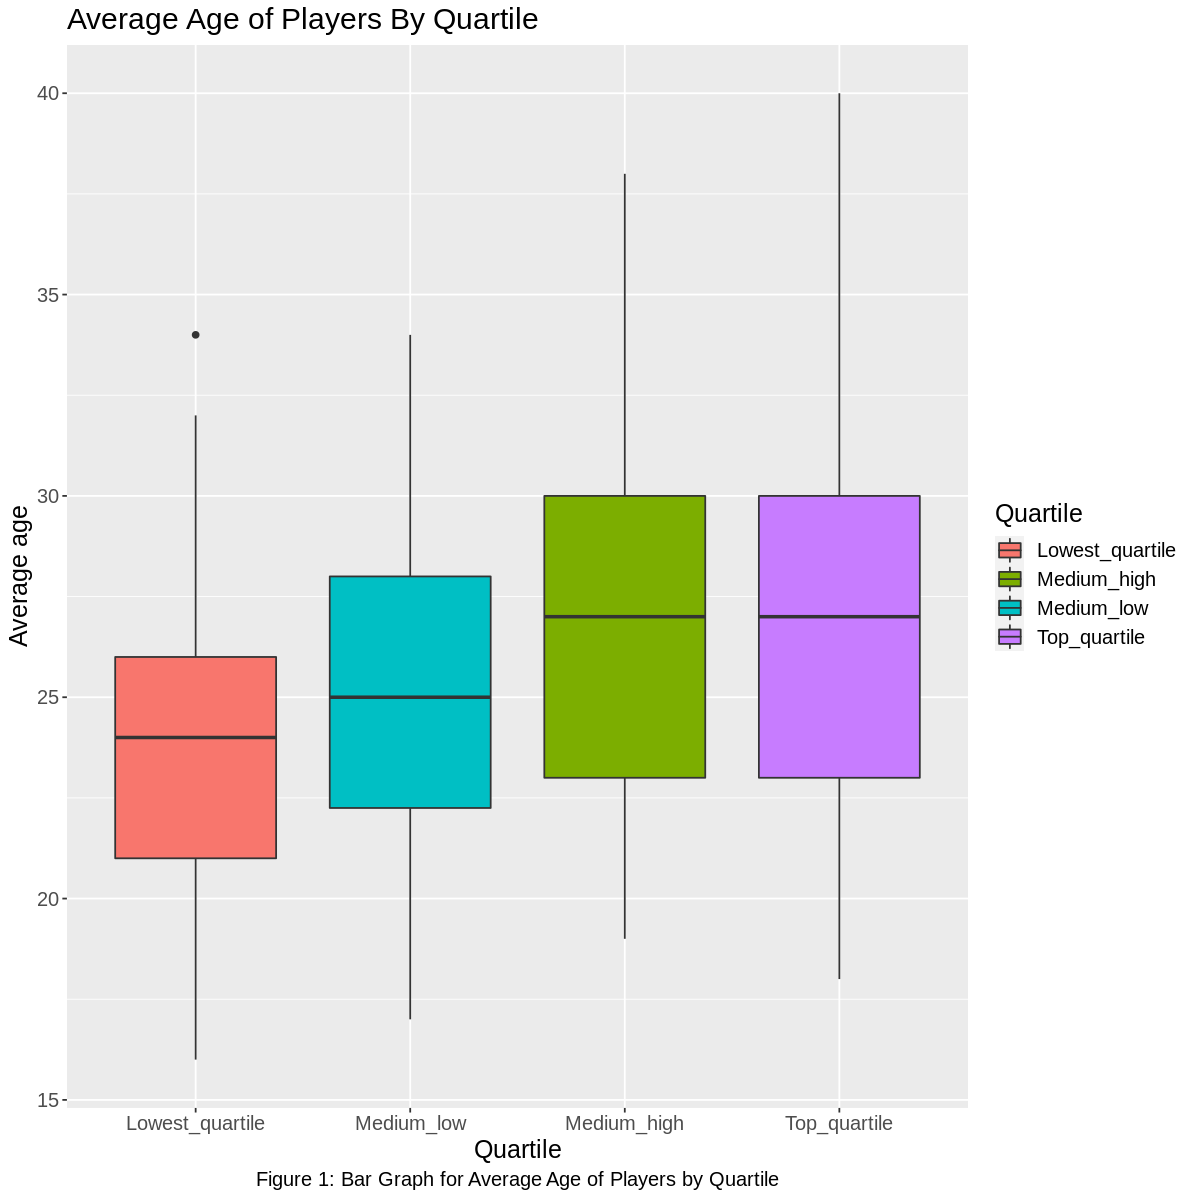

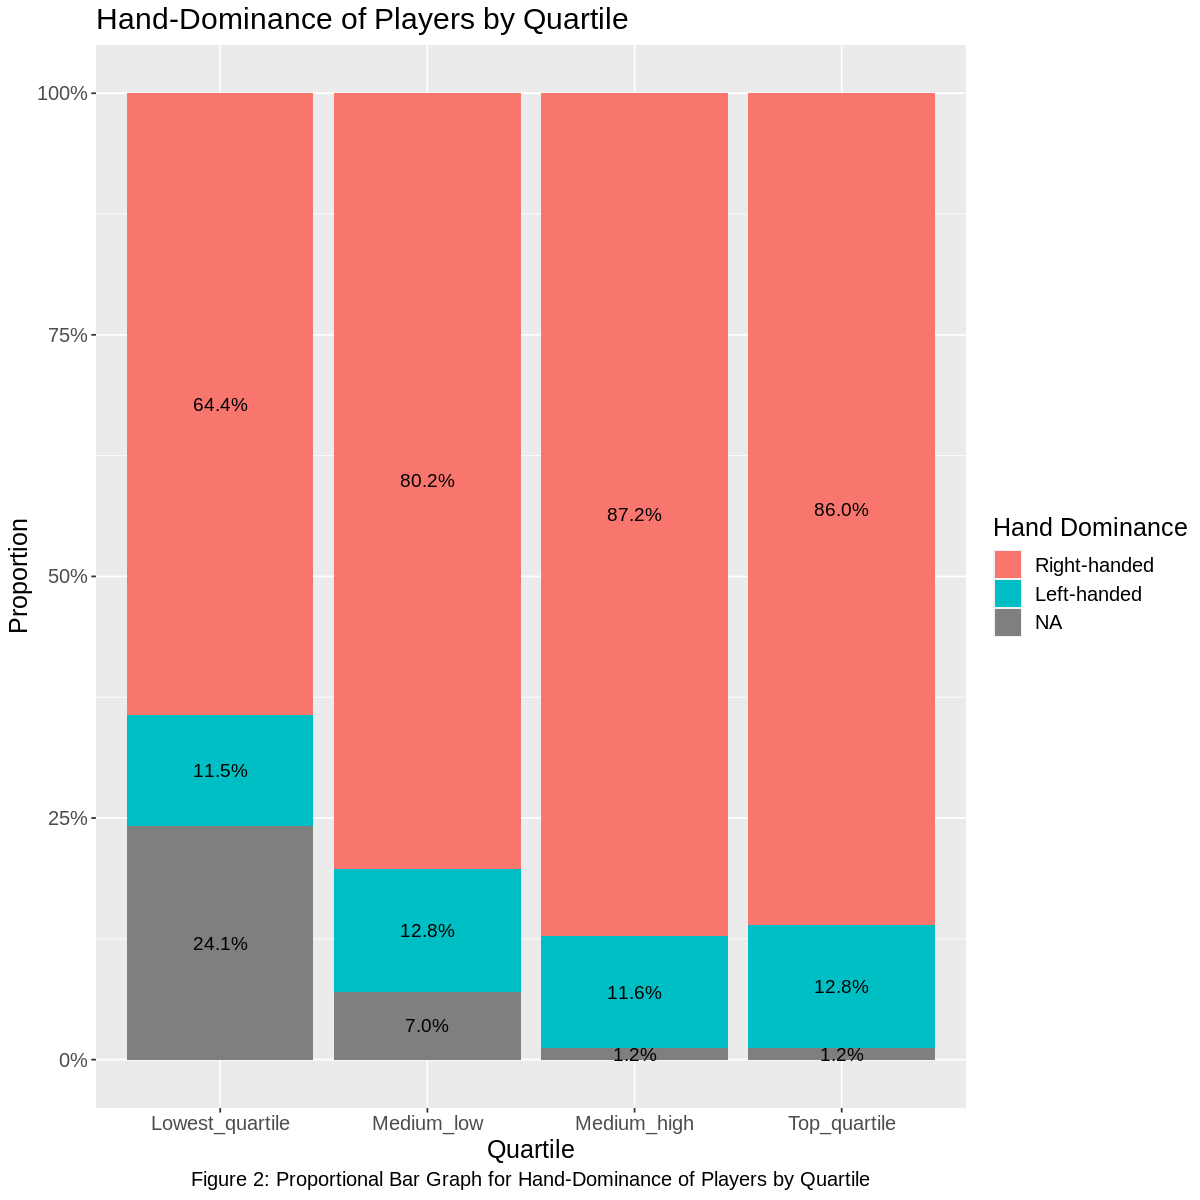

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
# Create plots sorted by Quartile for each predictor variable 

# Filter the bins so that they exclude the Other category
average_age <- tennis_bins |> filter(binned_cr != "Other")

# Create a box plot showing the average age by Quartile
low_vs_age_plot <- ggplot(average_age, aes(x = factor(binned_cr, levels = c("Lowest_quartile", "Medium_low", "Medium_high", "Top_quartile")),
                                           y = Age, fill = binned_cr)) +
                    geom_boxplot() + ggtitle("Average Age of Players By Quartile") + 
                    labs(x = "Quartile", y = "Average age", fill = "Quartile", caption = "Figure 1: Bar Graph for Average Age of Players by Quartile") +
                    theme(text = element_text(size = 15)) + theme(plot.caption = element_text(hjust = 0.5))

# Find the proportion of players who play left or right handed, or NA, seperated by Quartile
hand_prop <- tennis_bins |> filter(binned_cr != "Other") |> group_by(binned_cr, Plays) |> summarise(count = n()) |>
                            group_by(binned_cr) |> mutate(proportion = count / sum(count))

# Create a proportionality stacked bar plot of right vs left-handed Players by Quartile
plays_prop_plot <- ggplot(hand_prop, aes(x = factor(binned_cr, levels = c("Lowest_quartile", "Medium_low", "Medium_high", "Top_quartile")),
                                         y = proportion, fill = Plays)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Quartile", y = "Proportion", fill = "Hand Dominance", title = "Hand-Dominance of Players by Quartile", 
                         caption = "Figure 2: Proportional Bar Graph for Hand-Dominance of Players by Quartile") +
                    geom_text(aes(label = sprintf("%.1f%%", proportion*100)), 
                                    position = position_stack(vjust = 0.5), 
                                    size = 4) +
                    scale_y_continuous(labels = percent_format()) + theme(plot.caption = element_text(hjust = 0.5)) + theme(text = element_text(size = 15))
 


low_vs_age_plot
plays_prop_plot

### Discussion of Exploratory Data Analysis on Predictors

##### Age Data
As seen on Fig. 1, rank numbers were divided into four quartiles to identify trends that exist within each quartile and compare them. Specifically, we can analyze the age distribution and median age of players in different ranks. We are able to see that young players, with a median age of approximately 24, make up the majority of the lowest rank quartile. In the medium low quartile, players have a median age of 25. In the top two quartiles, players have near identical median ages of approximately 27. While each box points to a distinct median age, it is important to note the large age range covered by each box, as represented by the length of the box and whiskers, especially at the higher quartiles. This indicates that the presented data may not be as reliable as we would hope. Overall, this box plot visualization suggests a weak positive nonlinear correlation between age and player rank, with a plateau near age 27. A possible explanation for this increase in rank as players age is the increase in experience and practice that players acquire over years of playing the sport. Our explanation is partly justified by a 2017 study, which found that in lower tiers, older players had an advantage over younger ones but in higher tiers, older players performed worse (Sridhara, 2021, pg 50-56). Our study contradicts the latter result because the trend reached a plateau in the higher quartiles. This may be because our study analyzed a different dataset which may have a different set of variables at play. 

##### Plays Data
As seen on Fig. 2, rank numbers were again split into four quartiles. Due to the nature of the bar chart, we were able to plot right-handed, left-handed, and N/A values within each quartile, which facilitates optimal visualization of the hand-dominance data. Roughly 10% of data values were N/A, and this is most exhibited by the lowest quartile having the greatest amount of NA values: over 24%. The relatively lower sample size suggests that the data from the lowest quartile might be even less reliable than the rest of the data. This can be explained by less meticulous records being maintained for low rank players. Upon examination of the quartiles, it is clear that there is a higher percentage of right-handed than left-handed players (roughly 85:15 ratio), but this trend is observed in each quartile, suggesting little to no correlation between hand-dominance and rank. This finding aligns with a previous study which shares that within larger sample sizes of professional tennis players, there was an equal proportion of left-handed and right-handed players (Wood and Aggleton, 1989, pg. 228).

## Data Analysis
### Fitting a linear regression model
Using our training data, we fit the model and create an equation to predict the current rank. After finding our equation, we calculate the RMSE and RMSPE to see how well our model fits the data.

In [7]:
# Create a model for our linear regression
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

# Next, create a recipe to predict with
tennis_recipe <- recipe(Current.Rank ~., data = tennis_lm_train) 

# Create a fit by combining our model and recipe together
tennis_fit <- workflow() |>
add_model(lm_spec) |>
add_recipe(tennis_recipe) |>
fit(data = tennis_lm_train)

tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)               Age  PlaysLeft-handed  
         422.839            -7.111            -5.190  


### Equation of our model's line
As seen above, our coefficients are (vertical intercept) 422.839 and -7.111 for the Age predictor, and -5.190 for the Plays predictor. Therefore, we can create the equation of the plane of best fit to the data:

$Current Rank = 422.839 -7.111 Age -5.190 (Plays(Left-handed))$

Note that in this equation the variable Plays, which has values Right-handed and Left-handed, is shown as $Plays(Left-handed)$. This is because we mutated it as a factor in the tidying process of our analysis. As such, Left-handed and Right-handed both correspond to 1 and 0 respectively. Since Right-handed is 0, it effectively disappears from our equation.

#### Calculating an RMSE

To evaluate the goodness of fit of our equation, we can calculate the RMSE

In [8]:
# With our fitted model, we make a prediction with our training data and pull the value.
tennis_rmse <- tennis_fit |> 
predict(tennis_lm_train) |>
bind_cols(tennis_lm_train) |>
metrics(truth = Current.Rank, estimate = .pred) |>
filter(.metric == "rmse") |>
pull()

print("RMSE for Current Rank")
print(tennis_rmse)

[1] "RMSE for Current Rank"
[1] 138.137


$$RMSE = 138.137$$

#### Calculating RMSPE

To evaluate how well our model performs on our testing set, we can calculate the RMSPE. 

In [9]:
# With the same fitted model, we make a prediction using our testing data
tennis_test_results <- tennis_fit |> 
predict(tennis_lm_test) |>
bind_cols(tennis_lm_test) 

# Pull the RMSPE from the predictions we made previously
tennis_rmspe <- tennis_test_results |> 
metrics(truth = Current.Rank, estimate = .pred) |>
filter(.metric == "rmse") |>
pull()

print("RMSPE for Current Rank")
print(tennis_rmspe)

[1] "RMSPE for Current Rank"
[1] 135.5216


$$RMSPE = 135.5216$$

Unfortunately, our value for RMSPE is very high, which is an indication of a poor fit for the data. An error of 135 is very high when considering we are only predicting within the top 500 ranks. The reasons why our model is not a good fit is examined in the Discussion.

## Linear Regression Model: Residual Plot
Here, we will create a residuals plot of our data.

Warning message:
“Removed 15 rows containing missing values (geom_point).”


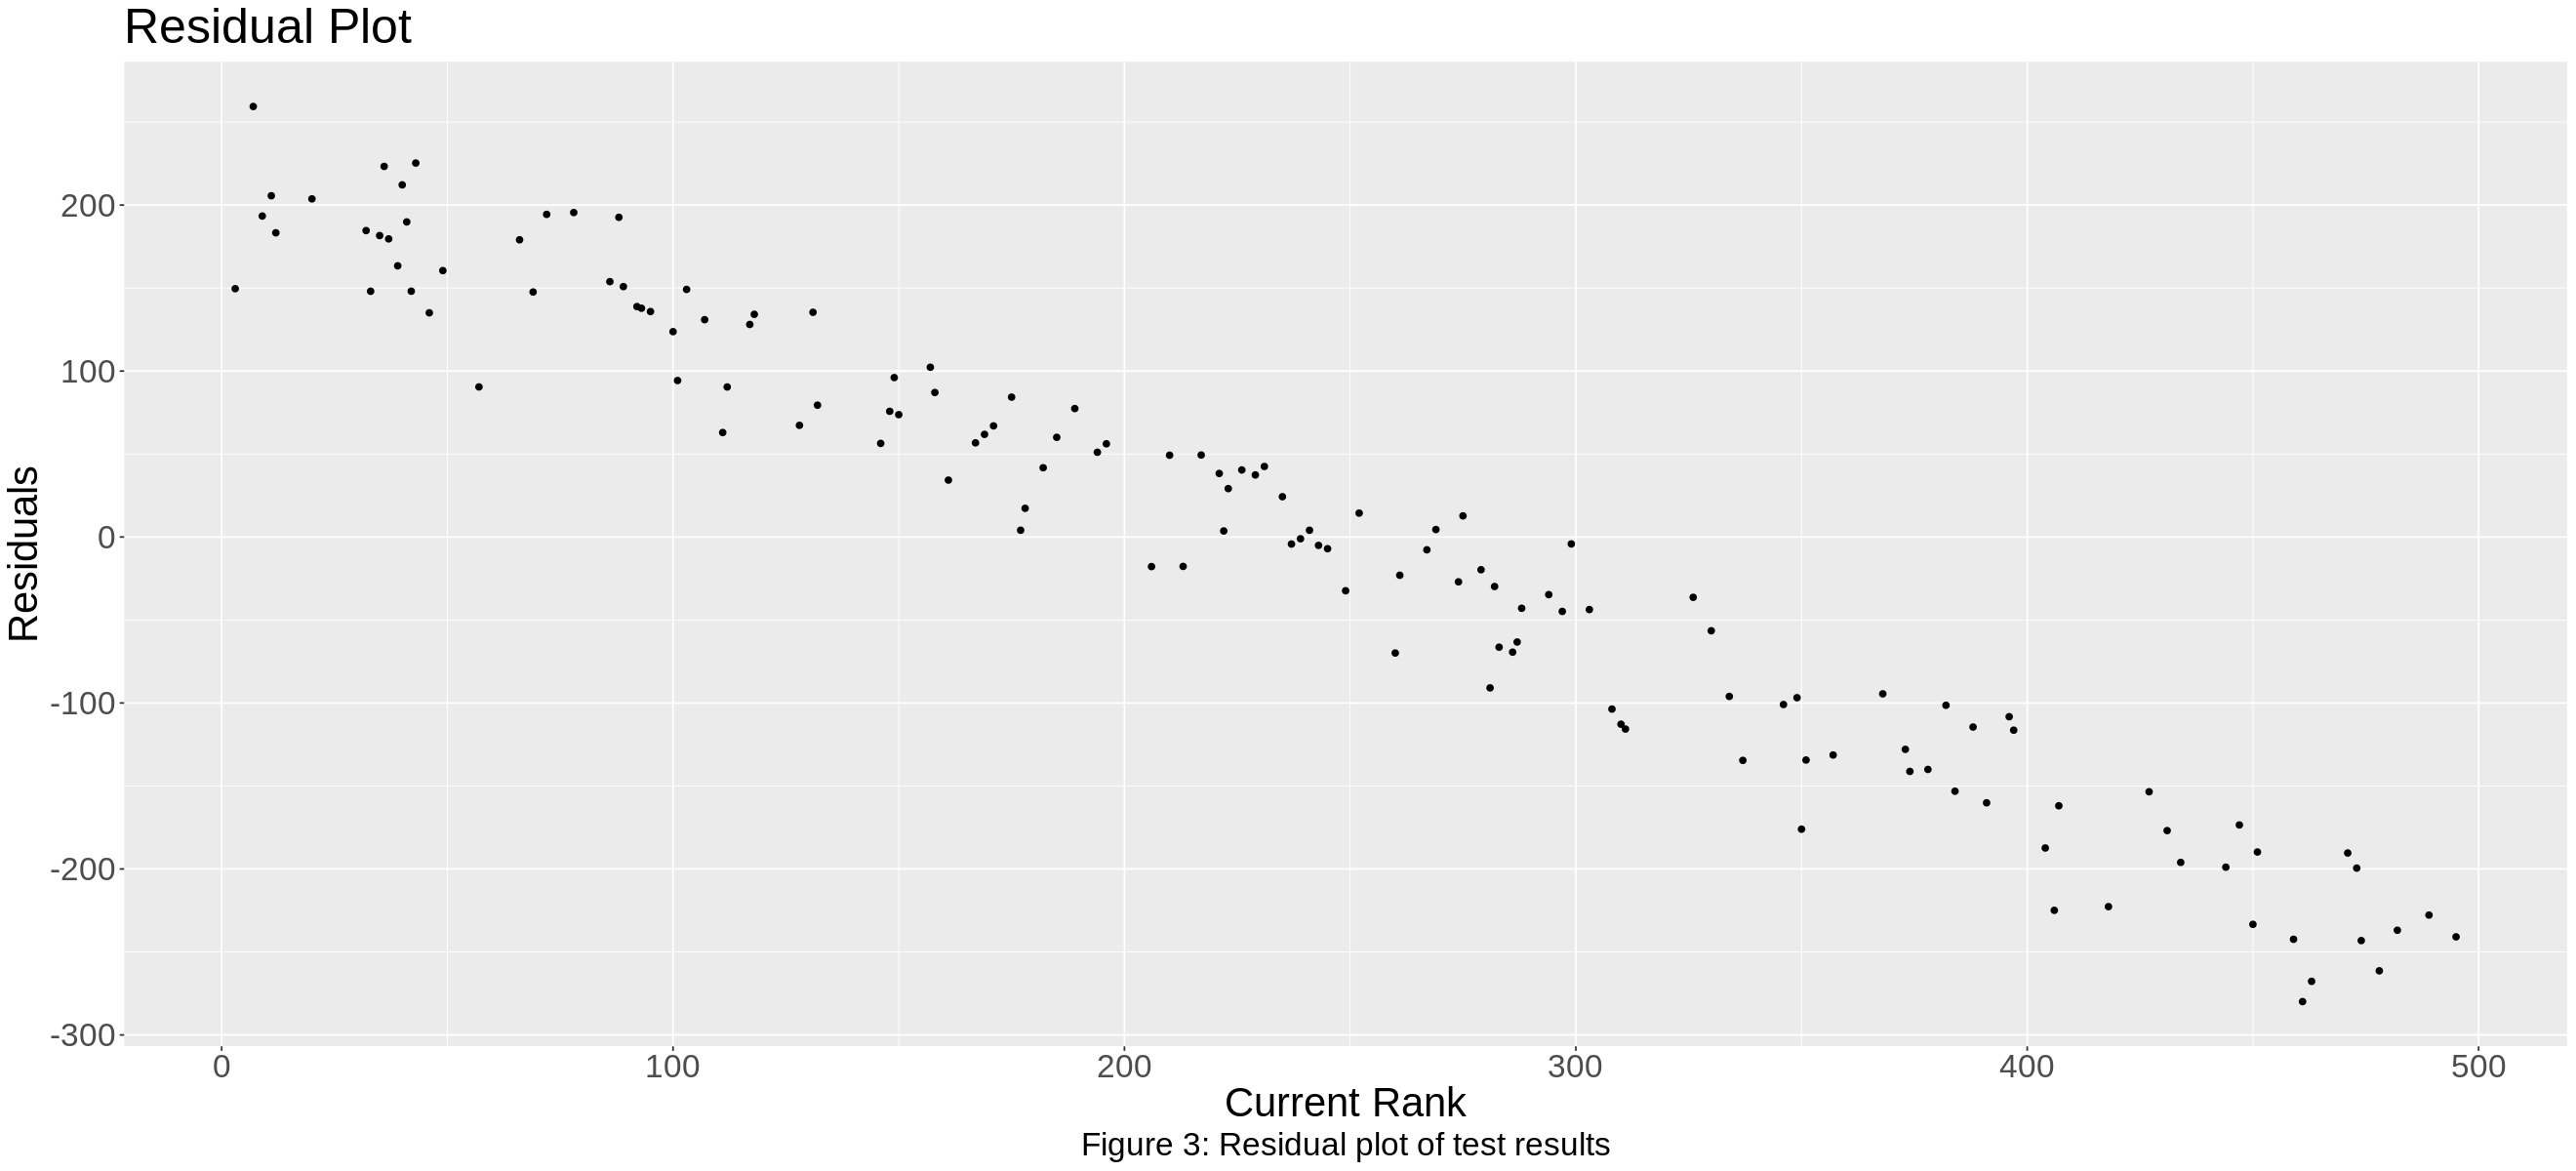

In [10]:
# Setting the width and height of our plot
options(repr.plot.width = 22, repr.plot.height = 10) 

# Plot our residuals(prediction - actual value) against our actual values.
residuals_plot <- tennis_test_results %>% 
mutate(residuals = `.pred` - `Current.Rank`) %>%
ggplot()+
geom_point(aes(x = `Current.Rank`, y = residuals)) + labs(x = "Current Rank", y = "Residuals", caption = "Figure 3: Residual plot of test results") + 
ggtitle("Residual Plot") +
theme(text = element_text(size = 25)) + theme(plot.caption = element_text(hjust = 0.5))

residuals_plot

As we can see in the residuals plot above, our model predicts best right around the middle of the ranks, approximately rank 250. When we reach the extremes, either rank 500 or 1, our model begins to fail quite seriously. Possible reasons for this will be examined in the Discussion section.

## KNN Regression

We will do another analysis, this time using KNN regression to determine if linear or KNN regression better fits this model.

#### Tidying Adjustments

We need to make adjustments to the tidying we performed at the start of our analysis. Although we did originally mutate 'Plays' to be a factor, for KNN regression we need 'Plays' to be a numerical variable. To maintain consistency between the KNN and linear regression methods, we used the same training and testing sets as before but mutated 'Plays' to be a number (Left-handed as 1 and Right-Handed as 0). Then, we omitted all missing values in both testing and training set as they were posing a problem in the later 'v_fold' setup of our analysis.

In [11]:
# Mutate Plays to a numerical column in our training data so that it can be used as a predictor in knn regression
# Set Left-Handed as 1 and Right-Handed as 0
tennis_knn_train <- tennis_lm_train |>
mutate(Plays = case_when(Plays == "Right-handed" ~ 0, 
                 Plays == "Left-handed" ~ 1,
                        ))
tennis_knn_test <- tennis_lm_test |>
mutate(Plays = case_when(Plays == "Right-handed" ~ 0, 
                 Plays == "Left-handed" ~ 1,
                        ))

# Omit all NAs in data so model will not have trouble making predictions due to the missing values
tennis_knn_train <- na.omit(tennis_knn_train)
tennis_knn_test <- na.omit(tennis_knn_test)

print("Table 5: Tennis Training knn Data")
tennis_knn_train

[1] "Table 5: Tennis Training knn Data"


Age,Plays,Current.Rank
<int>,<dbl>,<int>
22,0,31
20,0,104
19,0,22
⋮,⋮,⋮
25,0,486
23,1,429
32,0,416


### Finding the Optimum K

For our model specification, we will use the argument neighbors = tune() to find the k that best fits our model. We will use 7 fold cross-validation to get roughly 50 rows per fold. 7 was also chosen as it produces a good accuracy estimate while reducing computation power.

A tibble containing possible k values from 1 to 20 was created to test for the best k value between this range. Our model is looking for a k value that avoids underfitting or overfitting the data. 20 was selected as the upper bound because it offers a wider range of optimum k than 1-10 without greatly increasing the run time.   

In [12]:
set.seed(1234)
# Create a model for the knn regression, with the argument neighbors = tune()
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("regression")

# Create a recipe and scale and center all predictors using our training data
knn_recipe <- recipe(Current.Rank ~ Age + Plays, data = tennis_knn_train) |>  
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Set up cross-validation to help determine K. We use seven folds here to get roughly 50 rows per fold
knn_vfold <- vfold_cv(tennis_knn_train, v = 7, strata = Current.Rank) 

# Create a workflow by combining the recipe and model we just made
knn_workflow <- workflow() |> 
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

# We create a set of k values to be tested (1-20). 
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

# Perform the 7-fold cross-validation.
knn_results <- knn_workflow |> 
tune_grid(resamples = knn_vfold, grid = gridvals) |>
collect_metrics() 

# Filter for the k value that has the lowest RMSPE
k_best <- knn_results |> 
filter(.metric == "rmse") |>
filter(mean == min(mean))

print("Table 6: Best k value")
k_best

[1] "Table 6: Best k value"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,rmse,standard,141.6214,7,3.99834,Preprocessor1_Model19


As seen in Table 6, the best k value is 19. We can see it gives us the lowest mean value, or the lowest RMSPE. A new model specification is created with k = 19. Combining the recipe created previously with our new specification, we can create a new workflow. Our new model can make predictions on the testing data, which we can then evaluate the accuracy of using RMSPE. 

In [13]:
# Now we can retrain our model using our optimized k value, k = 19
knn_best_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = 19) |>
  set_engine("kknn") |>
  set_mode("regression")

# Create a new workflow by adding together our optimized model with our recipe
knn_best_fit <- workflow() |> 
  add_recipe(knn_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = tennis_knn_train)

# Make predictions on test data, and compute summary of regression quality
knn_summary <- knn_best_fit |>
  predict(tennis_knn_test) |>
  bind_cols(tennis_knn_test) |>
  metrics(truth = Current.Rank, estimate = .pred) |>
  filter(.metric == 'rmse')|> select(.estimate) |> pull()

knn_summary

[1] 138.2529

$$RMSPE = 138.2529$$

Unfortunately, our value for RMSPE is still very high, which is an indication of a poor fit for the data. Similarly to our linear regression results, an error of 138 is very high when considering we are predicting within the top 500 ranks. The reasons why our model is not a good fit will be examined in the Discussion.

### KNN Regression Model Plot

We create a visualization of our KNN model using the training data set with a separate plot for right-handed and left-handed players. Our goal was to visualize whether there were any trends or if our model was predicting differently for the two hand-dominances. Before plotting, we made predictions and bound it to our training set. We then created a scatter plot of the actual 'Current.Rank' values and  plotted a line of our model's predictions over top. The trend for right-handed and left-handed players is distinguished by color. 

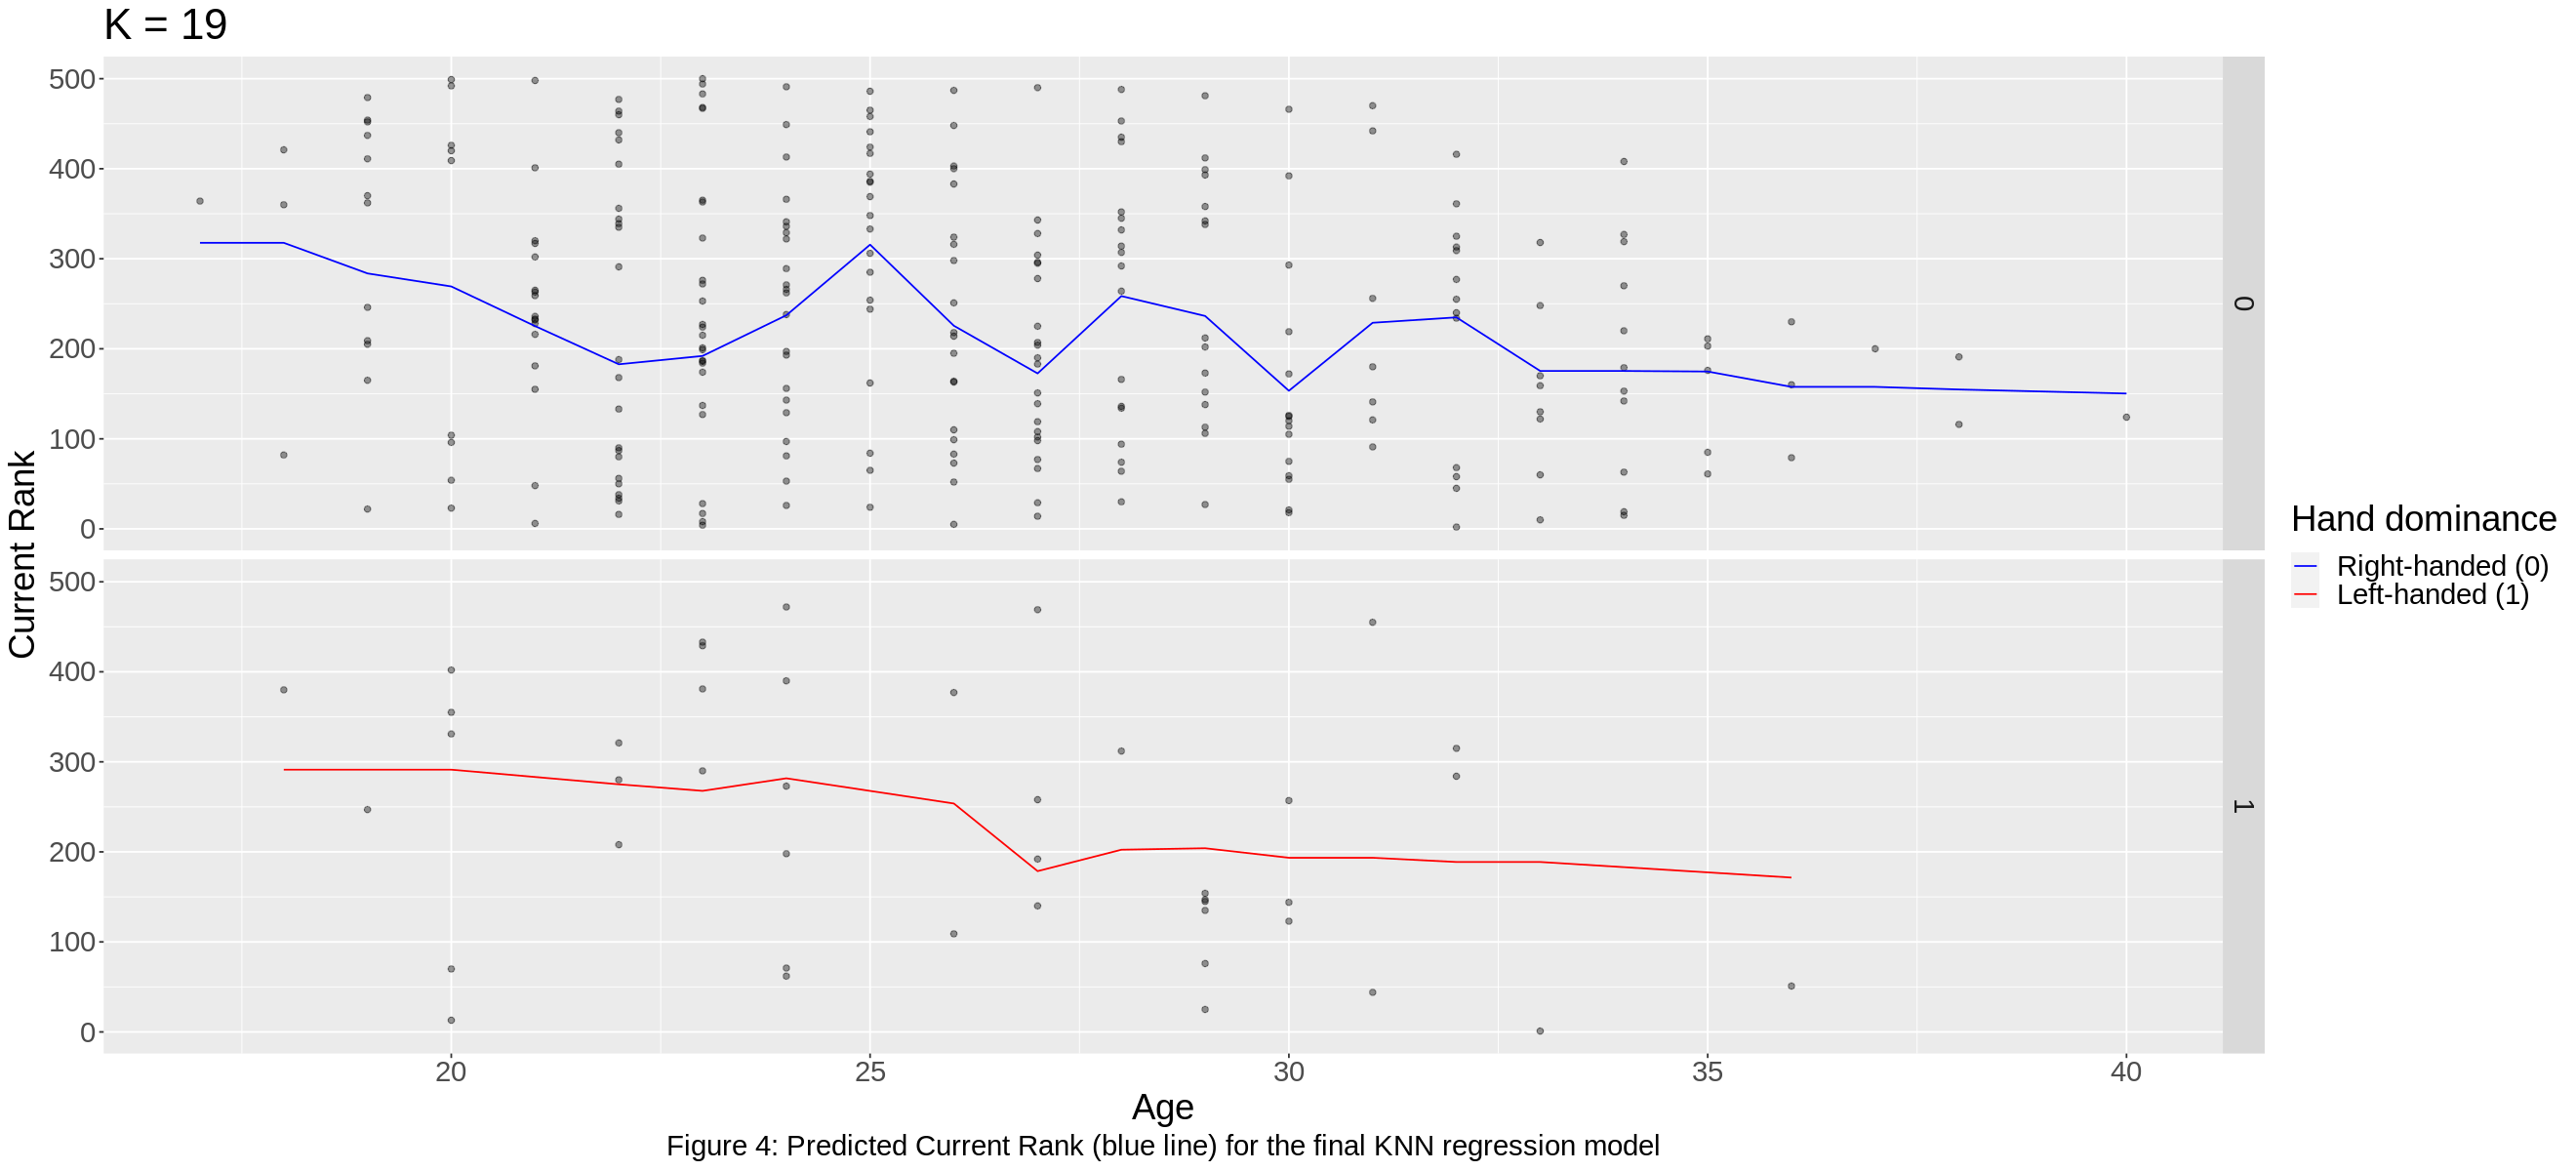

In [14]:
# Make predictions with the training set to plot in following graphs
knn_preds <- knn_best_fit |> 
  predict(tennis_knn_train) |>
  bind_cols(tennis_knn_train)

# Create the regression plot for Age and Current Rank, separated by Plays (hand-dominance)
knn_plot <- ggplot(knn_preds, aes(x = Age, y = Current.Rank, color = as.factor(Plays))) +
  geom_point(color = "black", alpha = 0.4) +
  geom_line(data = knn_preds, 
            mapping = aes(x = Age, y = .pred, color = as.factor(Plays))) +
  xlab("Age") +
  ylab("Current Rank") +
  ggtitle(paste0("K = ", k_best)) + labs(caption = "Figure 4: Predicted Current Rank (blue line) for the final KNN regression model") +
  theme(text = element_text(size = 22)) + theme(plot.caption = element_text(hjust = 0.5)) +
 scale_color_manual(values = c("blue", "red"), labels = c("Right-handed (0)", "Left-handed (1)")) +
  guides(color = guide_legend(title = "Hand dominance")) +
facet_grid(Plays ~.) 


knn_plot

Our linear regression value for RMSPE is $135.5216$ while our KNN regression value for RMSPE is $138.2529$. We notice that linear regression performs slightly better than knn regression, however the difference is marginal. 

## Discussion

Through this data analysis, we found little correlation between current rank and age or hand dominance. As we began our data analysis, we found that the height variable had a large amount of N/A values. Due to this limited sample size, the height variable did not seem like a good predictor of current rank and was likely to skew data and increase the RMSPE, so it was discarded and we instead focused on the “Age” and “Plays” variables. 

Finding the RMSE value to be 138.137 indicates that for every rank value our model predicts, the true rank value could be either 138.137 ranks higher or lower. Application of the model to the testing set resulted in a RMSPE value of 135.5216, which reveals that the model’s predictions of rank are slightly more accurate than expected. This margin of error, while not ideal, is reasonable. An obvious explanation of this can be linked to the small sample sizes in both the age and hand-dominance variables, suggesting that our results are not very reliable and cannot be generalized to larger populations. As previously stated, age offers a slight indication of player rank, as indicated by the trend of higher ranks towards higher ages. However, since outliers to this trend are plentiful, there remains only a slight correlation. Since little to no correlation exists between rank and hand-dominance, using this data as one of our predictors provides no increased accuracy to our predictions. 

A residuals plot was created to visualize how much predictions deviate from actual values. An ideal plot would show values centering closely around the “0” value, indicating near-perfect predictions for every rank, but unfortunately this was not exhibited by our plot, as indicated by Fig. 3. The plot showed that the model’s predictions are most accurate near the middle ranks (around 250), and worse as we approach either extremes. A possible reason for this is that the extreme variables may be more dispersed and have more variability, in which case, the model may not make accurate predictions due to the non-linearity within the data. As we discussed above, there is a non-linear relationship between age and rank which could be causing this effect. Continuing, another reason is that variables have a different impact at the various stages of a player’s career. For example, age may have a stronger impact on a player's rank when they are at a particular stage in their career. If most of the players in the dataset are around that stage, then the model will be better at predicting their rank based on that age. However, as we move away from that stage, the impact of age on current rank may weaken, and the model's predictions become less accurate. Continuing, our residual plot appears to show a downward sloping pattern, which signifies that a linear regression model is not the best fit for our data. The residual plot values should be more randomized and scattered, but an absence of that may indicate that our model is giving an inaccurate estimation of the higher and lower values in the plot. We can also notice a few outliers which may be skewing the data. 

Following the large error values from the linear regression model, we decided to test a KNN regression model to see if results improve. Our resulting RMPSE value of 138.2529 was found to be slightly worse than that of our linear regression model. This indicates that the linear regression model must be the superior choice in predicting current tennis rankings. A possible justification for this can be explained through one of the limitations of KNN regression which states that the accuracy of our predictions depends on the quality of the original data (Chatterjee, 2022). It is also important to note that the optimal K value showed a trend of decreasing error with increasing values of K, but due to restrictions of computational power, only K values ranging from 1-20 could be explored. 


Both linear and KNN regression did not predict current tennis ranking from the variables of age and hand-dominance very well. A general explanation for this is that the response variable of current rankings is a very difficult variable to predict and most likely has more factors at play than just players’ ages and dominant hands. As indicated by Fig. 3, the linear regression model may work best for predicting the ranks of players that do not fall at either extreme. The impact of these findings is that they contribute to the growing knowledge of the effects of various factors on success in tennis and call for additional studies to build on any trends found, such as the positive correlation between age and rank within lower rank quartiles. Future studies can build on the greatest limitation of this study by working with a larger sample size, and may also attempt to improve the accuracy of the KNN regression model by utilizing a larger K value.

## References

Chatterjee, Marina. “A Quick Introduction to KNN Algorithm.” Great Learning Blog: Free Resources What Matters to Shape Your Career!, 13 Dec. 2022, https://www.mygreatlearning.com/blog/knn-algorithm-introduction/. 

“History of Tennis.” Wikipedia, Wikimedia Foundation, 30 Jan. 2023,     https://en.wikipedia.org/wiki/History_of_tennis.

Sridhara, Shreyes. “An Analysis of Advantage Factors in Men’s Tennis – Handedness, Age, Height, and Rank.” International Journal of High School Research, vol. 3, no. 5, 2021, pp. 50–56., https://doi.org/10.36838/v3i5.10. 

Ultimate Tennis Statistics, https://www.ultimatetennisstatistics.com/.

Wood, C. J., and J. P. Aggleton. “Handedness in ‘Fast Ball’ Sports: Do Lefthanders Have an Innate Advantage?” British Journal of Psychology, vol. 80, no. 2, 1989, pp. 227–240., https://doi.org/10.1111/j.2044-8295.1989.tb02316.x. 
